  0%|          | 0/81 [00:00<?, ?it/s]

,dataset_name,model_name,MAP@1,MAP@3,MAP@5,MAP@10,MAP@100,MAP@1000
0,arguana,BAAI/bge-reranker-v2-m3,0.25200,0.35467,0.38647,0.40391,0.41608,0.41608
1,dbpedia-entity,BAAI/bge-reranker-v2-m3,0.05952,0.10140,0.11931,0.14972,0.20320,0.20320
2,fiqa,BAAI/bge-reranker-v2-m3,0.23052,0.32733,0.35081,0.36176,0.37075,0.37075
3,nfcorpus,BAAI/bge-reranker-v2-m3,0.05669,0.09943,0.11191,0.12754,0.15261,0.15261
4,scidocs,BAAI/bge-reranker-v2-m3,0.03320,0.06683,0.07858,0.09125,0.10666,0.10666
...,...,...,...,...,...,...,...,...
76,scidocs,loki_reranker_qwen2_5-0-5b-5,0.00240,0.00573,0.00629,0.00885,0.02234,0.02234
77,scifact,loki_reranker_qwen2_5-0-5b-5,0.03100,0.04778,0.05218,0.06006,0.08428,0.08428
78,trec-covid-v2,loki_reranker_qwen2_5-0-5b-5,0.00146,0.00341,0.00564,0.01112,0.08207,0.08207
79,vihealthqa,loki_reranker_qwen2_5-0-5b-5,0.01133,0.01633,0.01933,0.02349,0.03141,0.03141


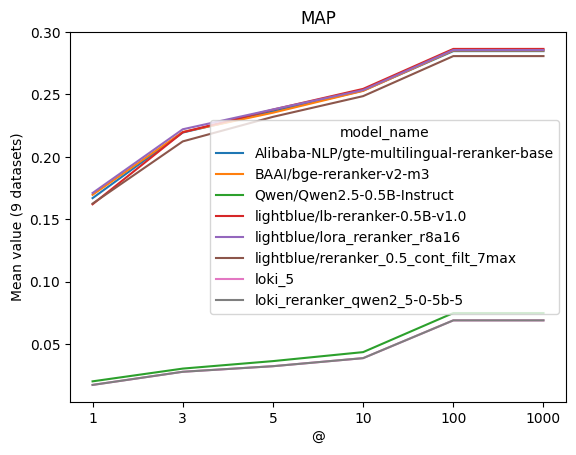

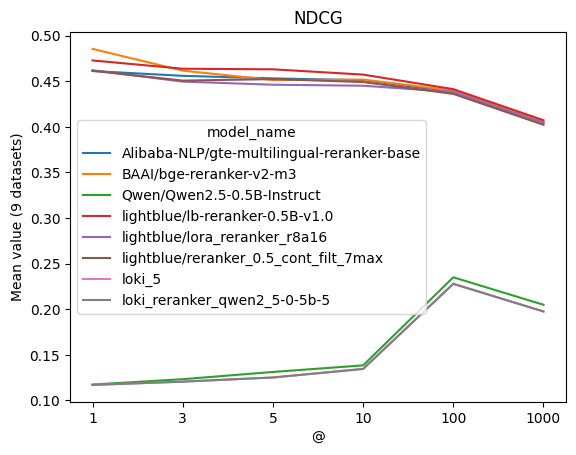

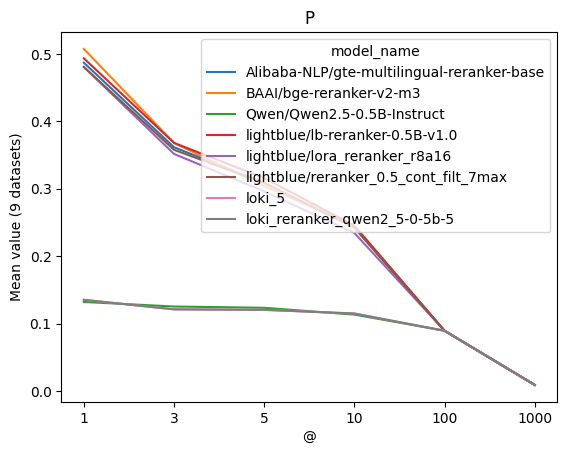

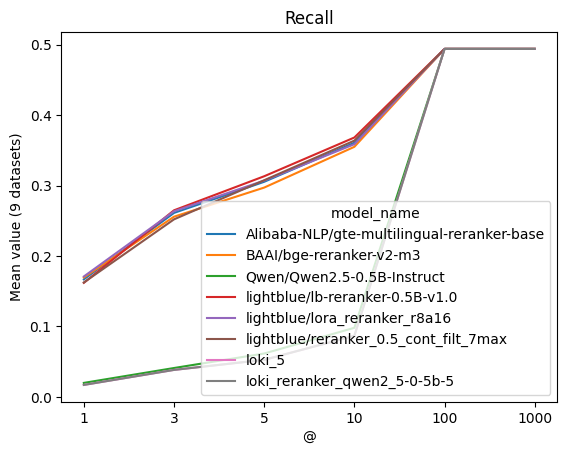

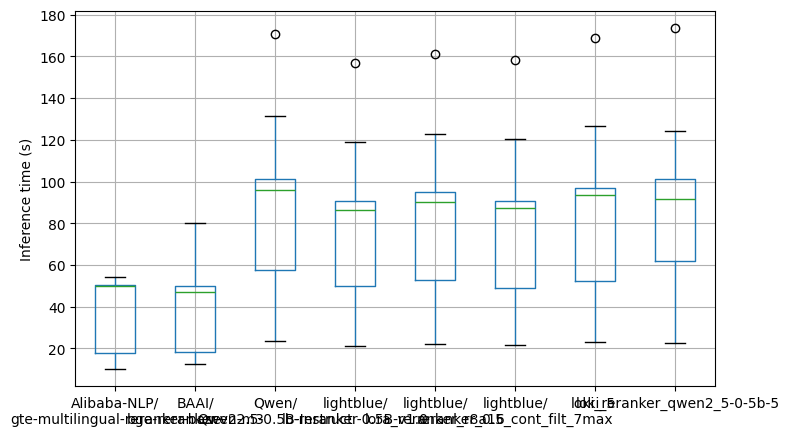

In [1]:
from glob import glob
import pandas as pd
from tqdm.auto import tqdm

paths = glob("./bier_results/**/*.parquet")

df_list = []

for p in tqdm(paths):
    single_df = pd.read_parquet(p)
    df_list.append(pd.DataFrame(single_df.iloc[0].to_dict(),
             index=[(single_df.index[0], single_df.index[1])]
             ))
all_df = pd.concat(df_list).reset_index(drop=False)
all_df["dataset_name"] = all_df["index"].str[0]
all_df["model_name"] = all_df["index"].str[1]
metric_names = ['MAP', 'NDCG', 'P', 'Recall']
metrics_k_list = [1, 3, 5, 10, 100, 1000]

for metric_name in metric_names:
    grouped = all_df[
        (all_df["model_name"] != "cross-encoder/ms-marco-electra-base") # Remove this because the results outlie so much lower that they detract from the graph
    ].rename(
        columns={f"{metric_name}@{k}": k for k in metrics_k_list}
    ).groupby("model_name")[metrics_k_list].agg(['mean', 'std'])

    # Extract mean and standard deviation
    means = grouped.T.loc[[x[1] == "mean" for x in grouped.T.index]].reset_index(level=1, drop=True)
    std = grouped.T.loc[[x[1] == "std" for x in grouped.T.index]].reset_index(level=1, drop=True)

    # Plot with error bars
    ax = means.plot(title=metric_name)

    ax.set_xlabel("@")
    ax.set_ylabel("Mean value (9 datasets)")
all_df["Model name"] = all_df["model_name"].apply(lambda x: x.replace("/", "/\n"))
ax = all_df[
        (all_df["model_name"] != "cross-encoder/ms-marco-electra-base") # Remove this because the results outlie so much lower that they detract from the graph
    ].boxplot(column="time", by="Model name", figsize=(8, 5))
ax.set_ylabel("Inference time (s)")
ax.set_xlabel("")
ax.set_title("")
ax.figure.suptitle("")
metric_names = ['MAP', 'NDCG', 'P', 'Recall']
metrics_k_list = [1, 3, 5, 10, 100, 1000]

all_df[["dataset_name", "model_name"] + [f"MAP@{k}" for k in metrics_k_list]]
# all_df[["dataset_name", "model_name"] + [f"Recall@{k}" for k in metrics_k_list]]
# all_df[["dataset_name", "model_name"] + [f"NDCG@{k}" for k in metrics_k_list]]
# all_df[["dataset_name", "model_name"] + [f"P@{k}" for k in metrics_k_list]]

